# June 13th, 2021

**Motivation**: Exploring brain globe.  Very convenient way of working with different atlases, including the one by Allen Institute.  In this update I explore bg_atlasapi, bg_space, and morphapi.  Very nice hierarchy tree of structures in Allen atlas at the bottom.  </br>

In [6]:
import os
import ants
import nrrd

import sys
import collections
import numpy as np
import pandas as pd
import nibabel as nib
import networkx as nx
import operator as op
from copy import deepcopy as dc
from os.path import join as pjoin

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'

extras_dir = pjoin(os.environ['HOME'], 'Dropbox/git/jb-Ca-fMRI/_extras')

## Show atlases

In [3]:
from bg_atlasapi import show_atlases
show_atlases()

                                                                                  
                                                                                  
                                Brainglobe Atlases                                
╭──────────────────────────────────┬────────────┬───────────────┬────────────────╮
│ Name                             │ Downloaded │ Local version │ Latest version │
├──────────────────────────────────┼────────────┼───────────────┼────────────────┤
│ mpin_zfish_1um                   │     ✔      │      1.0      │      1.0       │
│ allen_mouse_25um                 │     ✔      │      1.2      │      1.2       │
│ allen_mouse_100um                │     ✔      │      1.2      │      1.2       │
│ example_mouse_100um              │    ---     │      ---      │      1.2       │
│ allen_mouse_10um                 │    ---     │      ---      │      1.2       │
│ allen_mouse_50um                 │    ---     │      ---      │      1.2       │
│ allen_human_500um                │    ---     │      ---      │      0.1       │
│ kim_mouse_10um                   │    ---     │      ---      │      1.0       │
│ kim_mouse_25um                   │    ---     │      ---      │      1.0       │
│ kim_mouse_50um                   │    ---     │      ---      │      1.0       │
│ kim_mouse_100um                  │    ---     │      ---      │      1.0       │
│ osten_mouse_10um                 │    ---     │      ---      │      1.1       │
│ osten_mouse_25um                 │    ---     │      ---      │      1.1       │
│ osten_mouse_50um                 │    ---     │      ---      │      1.1       │
│ osten_mouse_100um                │    ---     │      ---      │      1.1       │
╰──────────────────────────────────┴────────────┴───────────────┴────────────────╯

## Allen mouse 100um

In [4]:
from bg_atlasapi.bg_atlas import BrainGlobeAtlas
atlas = BrainGlobeAtlas("allen_mouse_100um")

allen mouse atlas (res. 100um)
From: http://www.brain-map.org (Wang et al 2020, https://doi.org/10.1016/j.cell.2020.04.007 )


In [5]:
atlas.metadata

{'name': 'allen_mouse',
 'citation': 'Wang et al 2020, https://doi.org/10.1016/j.cell.2020.04.007',
 'atlas_link': 'http://www.brain-map.org',
 'species': 'Mus musculus',
 'symmetric': True,
 'resolution': [100.0, 100.0, 100.0],
 'orientation': 'asr',
 'version': '1.2',
 'shape': [132, 80, 114],
 'trasform_to_bg': [[1.0, 0.0, 0.0, 0.0],
  [0.0, 1.0, 0.0, 0.0],
  [0.0, 0.0, 1.0, 0.0],
  [0.0, 0.0, 0.0, 1.0]],
 'additional_references': []}

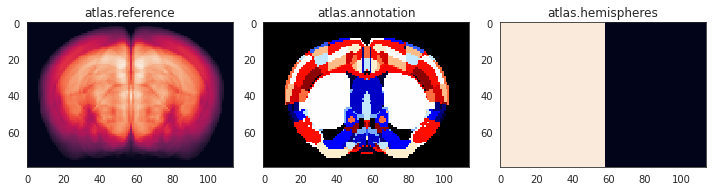

In [5]:
sns.set_style('white')
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

axes[0].imshow(atlas.reference.mean(0))
axes[0].set_title('atlas.reference')

slice_idx = 50
axes[1].imshow(atlas.annotation[slice_idx], cmap='flag_r', vmax=20000)
axes[1].set_title('atlas.annotation')

axes[2].imshow(atlas.hemispheres.mean(0))
axes[2].set_title('atlas.hemispheres')

fig.tight_layout()
plt.show()

In [6]:
atlas.lookup_df

,acronym,id,name
0,root,997,root
1,grey,8,Basic cell groups and regions
2,CH,567,Cerebrum
3,CTX,688,Cerebral cortex
4,CTXpl,695,Cortical plate
...,...,...,...
835,V3,129,third ventricle
836,AQ,140,cerebral aqueduct
837,V4,145,fourth ventricle
838,V4r,153,lateral recess


In [7]:
atlas.lookup_df[atlas.lookup_df.id == 315]

,acronym,id,name
5,Isocortex,315,Isocortex


In [8]:
atlas.lookup_df[atlas.lookup_df.acronym == 'VISp']

,acronym,id,name
148,VISp,385,Primary visual area


In [9]:
from pprint import pprint
VISp = atlas.structures["VISp"]
pprint(VISp)

{'acronym': 'VISp',
 'id': 385,
 'mesh': None,
 'mesh_filename': PosixPath('/home/hadi/.brainglobe/allen_mouse_100um_v1.2/meshes/385.obj'),
 'name': 'Primary visual area',
 'rgb_triplet': [8, 133, 140],
 'structure_id_path': [997, 8, 567, 688, 695, 315, 669, 385]}


In [10]:
atlas.get_structure_ancestors('Isocortex')

['root', 'grey', 'CH', 'CTX', 'CTXpl']

In [11]:
atlas.get_structure_descendants('VISp')

['VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b']

In [12]:
atlas.get_structure_descendants('MOs')

['MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b']

In [13]:
atlas.structure_from_coords([51, 55, 40])

672

In [14]:
atlas.get_structure_ancestors(672)

['root', 'grey', 'CH', 'CNU', 'STR', 'STRd']

## How to use BG-Space

In [15]:
import bg_space as bgs

In [16]:
stack = np.random.rand(3, 2, 4)

source_origin = "lsa"
target_origin = "ipr"
mapped_stack = bgs.map_stack_to(source_origin, target_origin, stack)
stack.shape, mapped_stack.shape

((3, 2, 4), (2, 4, 3))

In [17]:
annotations = np.array([[0, 0, 0], [2, 1, 3]])  # related point annotations
source_space = bgs.AnatomicalSpace(source_origin, stack.shape)
target_space = bgs.AnatomicalSpace(target_origin, mapped_stack.shape)

In [18]:
source_space

<BGSpace AnatomicalSpace object>
origin: ('Left', 'Superior', 'Anterior')
sections: ('Sagittal plane', 'Horizontal plane', 'Frontal plane')
shape: (3, 2, 4)

In [19]:
target_space

<BGSpace AnatomicalSpace object>
origin: ('Inferior', 'Posterior', 'Right')
sections: ('Horizontal plane', 'Frontal plane', 'Sagittal plane')
shape: (2, 4, 3)

In [20]:
transformation_matrix = source_space.transformation_matrix_to(target_space)
transformation_matrix

array([[ 0., -1.,  0.,  2.],
       [ 0.,  0., -1.,  4.],
       [-1.,  0.,  0.,  3.],
       [ 0.,  0.,  0.,  1.]])

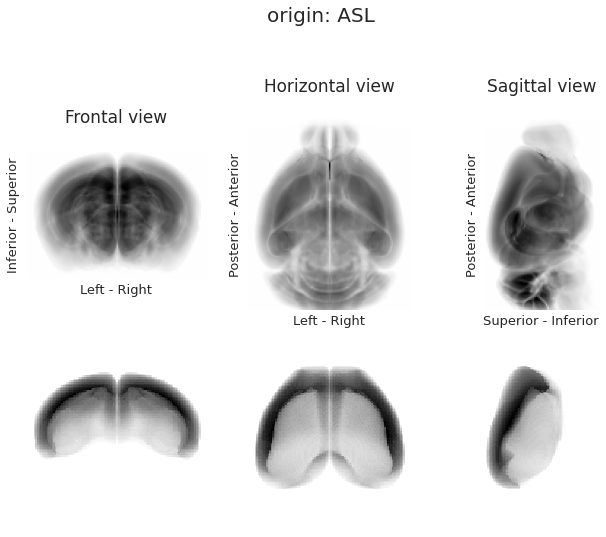

In [21]:
sc = bgs.AnatomicalSpace(origin="asl")

sns.set_style('white')
fig, axes = plt.subplots(2, 3, figsize=(9, 7))

for i, (plane, labels) in enumerate(zip(sc.sections, sc.axis_labels)):
    axes[0, i].imshow(atlas.reference.mean(i), interpolation='antialiased', cmap='Greys')

    axes[0, i].set_title(f"{plane.capitalize()} view\n", fontsize=17)
    axes[0, i].set_ylabel(labels[0], fontsize=13)
    axes[0, i].set_xlabel(labels[1], fontsize=13)
    
    axes[1, i].imshow(atlas.get_structure_mask('Isocortex').mean(i), interpolation='none', cmap='Greys')
    
    for j in range(2):
        _ = list(map(lambda x: x.set_visible(False), axes[j, i].spines.values()))
        axes[j, i].set_xticks([])
        axes[j, i].set_yticks([])
    
fig.suptitle('origin: ' + '{:s}'.format(sc.origin_string).upper(), fontsize=20, y=1.06)
fig.tight_layout()
plt.show()

## Morphapi

### 1) Allen Morphology

In [22]:
from morphapi.api.allenmorphology import AllenMorphology

am = AllenMorphology()

# Select mouse neurons in the primary visual cortex
neurons = am.neurons.loc[
    (am.neurons.species == "Mus musculus") &
    (am.neurons.structure_area_abbrev == "VISp")
]

# Download some of these neurons
neurons = am.download_neurons(neurons[:5].id.values)

embedWindow(verbose=True): could not load ipyvtk_simple try:
> pip install -U git+https://github.com/Kitware/ipyvtk-simple.git


Output()

In [23]:
neuron = neurons[0]
neuron.create_mesh()

({'soma': (Mesh)0x7f5e84f7b6a0,
  'axon': None,
  'apical_dendrites': (Mesh)0x7f5fac94c3a0,
  'basal_dendrites': (Mesh)0x7f5fac94c280},
 (Mesh)0x7f5fac9400a0)

### 2) Neuromorpho

In [24]:
from morphapi.api.neuromorphorg import NeuroMorpOrgAPI

api = NeuroMorpOrgAPI()

# ---------------------------- Downloading metadata --------------------------- #
# Get metadata for pyramidal neurons from the mouse cortex.
metadata, _ = api.get_neurons_metadata(
    size=10,  # Can get the metadata for up to 500 neurons at the time
    species="mouse",
    cell_type="pyramidal",
    brain_region="neocortex",
)

# To get a list of available query fields: print(api.fields)
# To get a list of valid values for a field: print(api.get_fields_values(field))
print("Neurons metadata:")
print(metadata[0])

# ---------------------------- Download morphology --------------------------- #
neurons = api.download_neurons(metadata[5])

Found metadata for 47577 neurons [4758 pages in total]
Returning metadata about 10 neurons from page 0
Neurons metadata:
{'neuron_id': 10047, 'neuron_name': 'TypeA-10', 'archive': 'Scanziani', 'note': None, 'age_scale': None, 'gender': 'Not reported', 'age_classification': 'not reported', 'brain_region': ['neocortex', 'occipital', 'layer 6'], 'cell_type': ['principal cell'], 'species': 'mouse', 'strain': 'transgenic', 'scientific_name': None, 'stain': 'biocytin', 'experiment_condition': ['Control'], 'protocol': 'in vitro', 'slicing_direction': 'coronal', 'reconstruction_software': 'Neurolucida', 'objective_type': 'oil', 'original_format': 'Neurolucida.dat', 'domain': 'Dendrites, Soma, No Axon', 'attributes': 'No Diameter, 3D, Angles', 'magnification': '63', 'upload_date': '2014-05-30', 'deposition_date': '2012-07-01', 'shrinkage_reported': 'Not Reported', 'shrinkage_corrected': '', 'reported_value': None, 'reported_xy': None, 'reported_z': None, 'corrected_value': None, 'corrected_xy':

### 3) MouseLight

In [25]:
from morphapi.api.mouselight import MouseLightAPI


# ---------------------------- Downloading neurons --------------------------- #
mlapi = MouseLightAPI()

# Fetch metadata for neurons with soma in the secondary motor cortex
neurons_metadata = mlapi.fetch_neurons_metadata(
    filterby="soma", filter_regions=["MOs"],
)

# Then we can download the files
neurons = mlapi.download_neurons(neurons_metadata[0])

Querying MouseLight API...


Exception: Query failed to run by returning code of 400. 
                    query {
                        searchNeurons {
                            
                queryTime
                totalCount
                
                neurons{
                tag
                id
                idNumber
                idString
                
                brainArea{
                    id
                    acronym
                    name
                    safeName
                    atlasId
                    aliases
                    structureIdPath
                }

                tracings{
                    soma{
                    x
                    y
                    z
                    radius
                    brainArea{
                        id
                        acronym
                    }
                    sampleNumber
                    parentNumber
                    
                    }
                
                id
                tracingStructure{
                    name
                    value
                    id
                }
                }
            }
    
                        }
                    }
                     -- 

{"errors":[{"message":"Cannot query field \"aliases\" on type \"BrainArea\". Did you mean \"aliasList\"?","locations":[{"line":20,"column":21}],"extensions":{"code":"GRAPHQL_VALIDATION_FAILED"}},{"message":"Cannot query field \"brainArea\" on type \"Node\". Did you mean \"brainAreaIdCcfV25\" or \"brainAreaIdCcfV30\"?","locations":[{"line":30,"column":21}],"extensions":{"code":"GRAPHQL_VALIDATION_FAILED"}}]}


### 4) Mpin Zebrafish

In [26]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [27]:
from morphapi.api.mpin_celldb import MpinMorphologyAPI


api = MpinMorphologyAPI()

# ----------------------------- Download dataset ----------------------------- #
"""
    If it's the first time using this API, you'll have to download the dataset
    with all of the neurons' data.
"""

# api.download_dataset()

# You can then inspect metadata about all neurons:
print(api.neurons_df.head())

# Get neurons for a given brain structure
neurons_ids = api.get_neurons_by_structure(837)

# and load the selected neurons
neurons = api.load_neurons(neurons_ids)

                                    filename   pos_ap   pos_si   pos_lr region
T_161116_7_2                T_161116_7_2.swc  584.073  39.4745  413.755      0
T_161116_24_2              T_161116_24_2.swc  227.416  286.822  391.047    808
T_160518_9_1                T_160518_9_1.swc  575.238  108.977  473.598      0
T_160708_HuCxBG_7_2  T_160708_HuCxBG_7_2.swc  531.976  143.489   295.06    833
T_160812_13_1              T_160812_13_1.swc  569.958  64.7669  254.375    867


## Brainrender

In [1]:
import os
import imio
import numpy as np

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'

In [2]:
from bg_space import AnatomicalSpace
from vedo import Volume
from brainrender import Scene, settings
from pathlib import Path
from myterial import blue_grey, orange, purple
from rich import print

In [5]:
import os
from os.path import join as pjoin
brainrender_ws = pjoin(os.environ['HOME'], 'Documents/workspaces/brainrender')
datafile = Path(pjoin(brainrender_ws, 'Mouse/comms3d.npy'))

print(f"[{purple}]Loading data")
data = np.load(datafile).astype('uint8')

Loading data

In [6]:
data = np.ma.masked_where(data == 0, data)

<matplotlib.colorbar.Colorbar object at 0x7f604ea645e0>

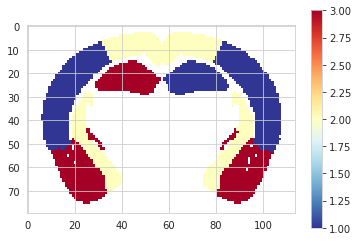

In [9]:
plt.imshow(data[70, ...], cmap='RdYlBu_r')
plt.colorbar()

<matplotlib.colorbar.Colorbar object at 0x7f604e956850>

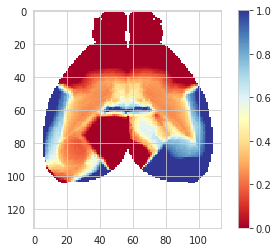

In [11]:
plt.imshow((data == 1).mean(1), cmap='RdYlBu')
plt.colorbar()

In [13]:
from bg_atlasapi.bg_atlas import BrainGlobeAtlas
atlas = BrainGlobeAtlas("allen_mouse_100um")

allen mouse atlas (res. 100um)
From: http://www.brain-map.org (Wang et al 2020, https://doi.org/10.1016/j.cell.2020.04.007 )


<matplotlib.colorbar.Colorbar object at 0x7f604d2a40a0>

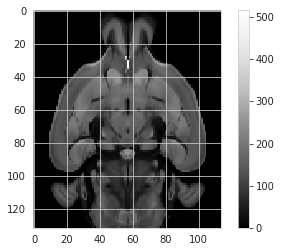

In [14]:
plt.imshow(atlas.reference[:, 56, :], cmap='Greys_r')
plt.colorbar()

### Agglo Hier Communities

In [19]:
from IPython.display import IFrame
IFrame('./_extras/Communities_AggloHier.html', width=900, height=700)

## Hierarchy

In [28]:
atlas.hierarchy.DEPTH, atlas.hierarchy.ROOT, atlas.hierarchy.WIDTH, atlas.hierarchy.ZIGZAG

(1, 0, 2, 3)

In [29]:
atlas.hierarchy.depth()

9

In [30]:
atlas.hierarchy.subtree(385).show()

VISp (385)
├── VISp1 (593)
├── VISp2/3 (821)
├── VISp4 (721)
├── VISp5 (778)
├── VISp6a (33)
└── VISp6b (305)



In [31]:
atlas.hierarchy.subtree(315).show(filter=lambda x: not x.is_leaf())

Isocortex (315)
├── ACA (31)
│   ├── ACAd (39)
│   └── ACAv (48)
├── AI (95)
│   ├── AId (104)
│   ├── AIp (111)
│   └── AIv (119)
├── AUD (247)
│   ├── AUDd (1011)
│   ├── AUDp (1002)
│   ├── AUDpo (1027)
│   └── AUDv (1018)
├── ECT (895)
├── FRP (184)
├── GU (1057)
├── ILA (44)
├── MO (500)
│   ├── MOp (985)
│   └── MOs (993)
├── ORB (714)
│   ├── ORBl (723)
│   ├── ORBm (731)
│   └── ORBvl (746)
├── PERI (922)
├── PL (972)
├── PTLp (22)
│   ├── VISa (312782546)
│   └── VISrl (417)
├── RSP (254)
│   ├── RSPagl (894)
│   ├── RSPd (879)
│   └── RSPv (886)
├── SS (453)
│   ├── SSp (322)
│   │   ├── SSp-bfd (329)
│   │   ├── SSp-ll (337)
│   │   ├── SSp-m (345)
│   │   ├── SSp-n (353)
│   │   ├── SSp-tr (361)
│   │   ├── SSp-ul (369)
│   │   └── SSp-un (182305689)
│   └── SSs (378)
├── TEa (541)
├── VIS (669)
│   ├── VISal (402)
│   ├── VISam (394)
│   ├── VISl (409)
│   ├── VISli (312782574)
│   ├── VISp (385)
│   ├── VISpl (425)
│   ├── VISpm (533)
│   └── VISpor (312782628)
└── VISC (

In [32]:
atlas.hierarchy.subtree(315).show()

Isocortex (315)
├── ACA (31)
│   ├── ACAd (39)
│   │   ├── ACAd1 (935)
│   │   ├── ACAd2/3 (211)
│   │   ├── ACAd5 (1015)
│   │   ├── ACAd6a (919)
│   │   └── ACAd6b (927)
│   └── ACAv (48)
│       ├── ACAv1 (588)
│       ├── ACAv2/3 (296)
│       ├── ACAv5 (772)
│       ├── ACAv6a (810)
│       └── ACAv6b (819)
├── AI (95)
│   ├── AId (104)
│   │   ├── AId1 (996)
│   │   ├── AId2/3 (328)
│   │   ├── AId5 (1101)
│   │   ├── AId6a (783)
│   │   └── AId6b (831)
│   ├── AIp (111)
│   │   ├── AIp1 (120)
│   │   ├── AIp2/3 (163)
│   │   ├── AIp5 (344)
│   │   ├── AIp6a (314)
│   │   └── AIp6b (355)
│   └── AIv (119)
│       ├── AIv1 (704)
│       ├── AIv2/3 (694)
│       ├── AIv5 (800)
│       ├── AIv6a (675)
│       └── AIv6b (699)
├── AUD (247)
│   ├── AUDd (1011)
│   │   ├── AUDd1 (527)
│   │   ├── AUDd2/3 (600)
│   │   ├── AUDd4 (678)
│   │   ├── AUDd5 (252)
│   │   ├── AUDd6a (156)
│   │   └── AUDd6b (243)
│   ├── AUDp (1002)
│   │   ├── AUDp1 (735)
│   │   ├── AUDp2/3 (251)
│   │   ├─

In [33]:
atlas.hierarchy.show(filter=lambda x: not x.is_leaf())

root (997)
├── VS (73)
│   ├── V4 (145)
│   └── VL (81)
├── fiber tracts (1009)
│   ├── cbf (960)
│   │   └── cbp (752)
│   │       ├── icp (1123)
│   │       └── scp (326)
│   ├── cm (967)
│   │   ├── IIIn (832)
│   │   ├── IIn (848)
│   │   ├── In (840)
│   │   │   └── lotg (21)
│   │   ├── VIIIn (933)
│   │   │   └── cVIIIn (948)
│   │   ├── VIIn (798)
│   │   ├── Vn (901)
│   │   │   └── sV (229)
│   │   ├── Xn (917)
│   │   └── drt (792)
│   │       └── cett (932)
│   │           └── dc (514)
│   ├── eps (1000)
│   │   ├── epsc (760)
│   │   ├── rust (863)
│   │   └── tsp (877)
│   ├── lfbs (983)
│   │   ├── cc (776)
│   │   │   └── fa (956)
│   │   ├── cst (784)
│   │   └── lfbst (896)
│   └── mfbs (991)
│       ├── mfbc (768)
│       │   ├── fxs (1099)
│       │   │   ├── fxpo (737)
│       │   │   └── hc (618)
│       │   └── st (301)
│       └── mfsbshy (824)
│           ├── mfbse (1083)
│           └── mfbsma (46)
└── grey (8)
    ├── BS (343)
    │   ├── HB (1065)
    │   │ 

In [ ]:
Volume()

In [38]:
atlas.lookup_df

,acronym,id,name
0,root,997,root
1,grey,8,Basic cell groups and regions
2,CH,567,Cerebrum
3,CTX,688,Cerebral cortex
4,CTXpl,695,Cortical plate
...,...,...,...
835,V3,129,third ventricle
836,AQ,140,cerebral aqueduct
837,V4,145,fourth ventricle
838,V4r,153,lateral recess


In [25]:
data_matrix

array([[[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 3, 3, 0],
        [0, 0, 0, ..., 3, 3, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 3, 3, 0],
        [0, 0, 0, ..., 3, 3, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)